Custom datasets are often used depending on the specific problem statement even though PyTorch has many built-in datasets.

Different domain libraries **(TorchVision, TorchText, TorchAudio, TorchRec)** contain data loading functions for different data sources.

However, sometimes these exisiting functions may not be enough. Then, always subclass **torch.utils.data.Dataset** and **customize it** accordingly.

In [1]:
import torch
from torch import nn

# Device-agnostic code setup
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1. Get data

In [2]:
import requests
import zipfile
from pathlib import Path

# Path to data dir
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# downloading and preparing the image dataset
if image_path.is_dir():
    print(f"{image_path} dir exists.")
else:
    print("Creating one, does not exist")
    image_path.mkdir(parents=True, exist_ok=True)
    # Download
    with open (data_path/"pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading...")
        f.write(request.content)
    # Preparing by unzipping the data
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_file:
        print("Unzipping and preparing...")
        zip_file.extractall(image_path)

data\pizza_steak_sushi dir exists.


### 2. Data Preparation (become one with data)

**Data preparation is paramount.** What am I trying to do here ? However, the main thing is to do inspection of the data.

**The goal is to take this data storage structure (str varies depending on the problem) and turn it into a dataset usable with PyTorch.** 

However, the premise is: become one with the data and then find a way to best turn it into a PyTorch-compatible dataset.

In [3]:
# Inspection of the data
import os
def walk_through_dir(dir_path):
    '''Walks through dir_path returning its contents.'''
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"{len(dirnames)} directories present and {len(filenames)} images present in {dirpath}")

In [4]:
walk_through_dir(image_path)

2 directories present and 0 images present in data\pizza_steak_sushi
3 directories present and 0 images present in data\pizza_steak_sushi\test
0 directories present and 25 images present in data\pizza_steak_sushi\test\pizza
0 directories present and 19 images present in data\pizza_steak_sushi\test\steak
0 directories present and 31 images present in data\pizza_steak_sushi\test\sushi
3 directories present and 0 images present in data\pizza_steak_sushi\train
0 directories present and 78 images present in data\pizza_steak_sushi\train\pizza
0 directories present and 75 images present in data\pizza_steak_sushi\train\steak
0 directories present and 72 images present in data\pizza_steak_sushi\train\sushi


In [5]:
# Setup train and test paths

train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

#### 2.1 Visualize an image

data\pizza_steak_sushi\train\pizza\393658.jpg
pizza 383 512


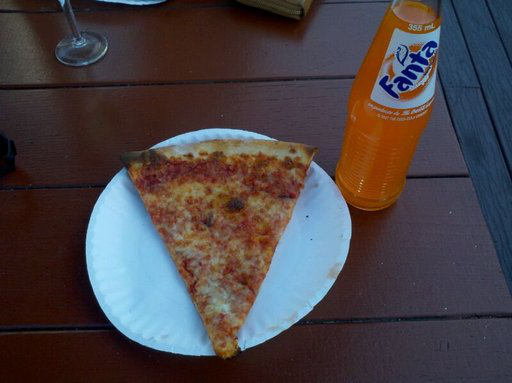

In [6]:
import random
from PIL import Image # Because (dealing with) images in the data storage structure are in image format (.jpg)

random.seed(45)

# 1. Get all image paths; .glob() to find all the files of a specific format
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class name from its path name
image_class = random_image_path.parent.stem

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(random_image_path)
print(image_class, img.height, img.width)
img

(np.float64(-0.5), np.float64(511.5), np.float64(382.5), np.float64(-0.5))

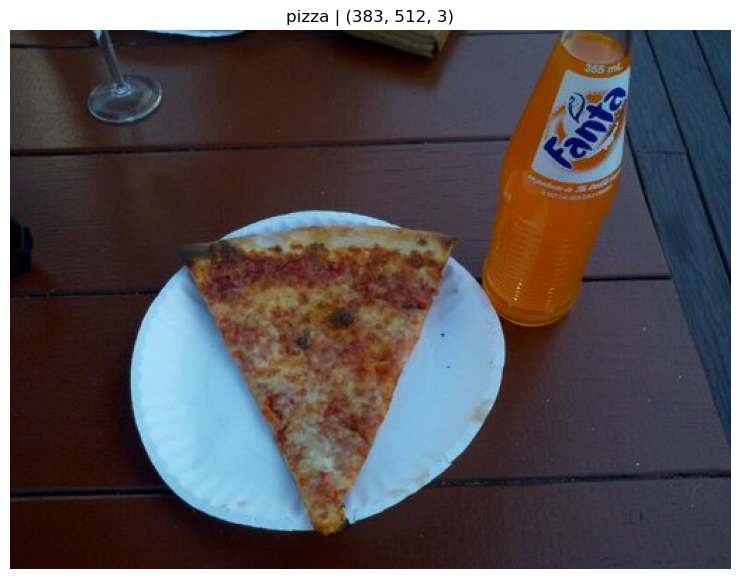

In [7]:
# The same visualization using images in the form of numbers -- arrays

import numpy as np
import matplotlib.pyplot as plt

# Image -> Array, turned
img_as_array = np.asarray(img)

# Plot the image with plt
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"{image_class} | {img_as_array.shape}")
plt.axis(False)

### 3. Transforming data

To load the image data into PyTorch, it first needs to be turned into tensors and then, turn them into a torch.utils.data.Dataset & subsequently, into a Dataloader. For it to be used with PyTorch.

Several kinds of pre-built datasets and their loaders are there in PyTorch **(torchvision.datasets, torchaudio.datasets, torchtext.datasets, torchrec.datasets)**.

In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#### 3.1 Transforming data with torchvision.transforms

One of the ways of converting images into tensors is by using torchvision.transforms module.

In [9]:
# Transforms to be performed over the images
# Compose() method is used to compile all these transformation steps
data_transform = transforms.Compose([
    # Image resize to 64x64
    transforms.Resize(size=(64,64)),
    # Random horizontal flips
    transforms.RandomHorizontalFlip(p=0.5), # p being the flip probability
    # Trun into a torch tensor
    transforms.ToTensor()
])

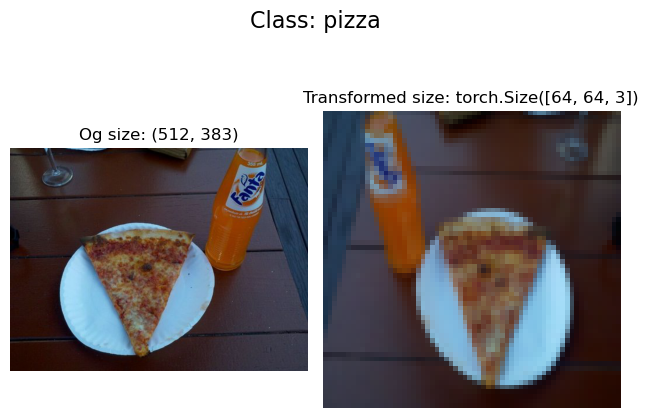

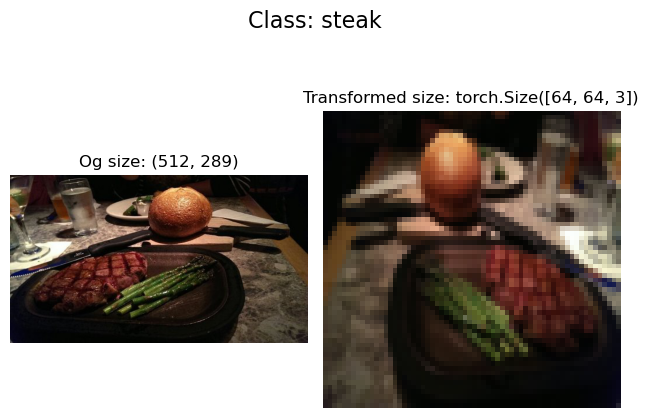

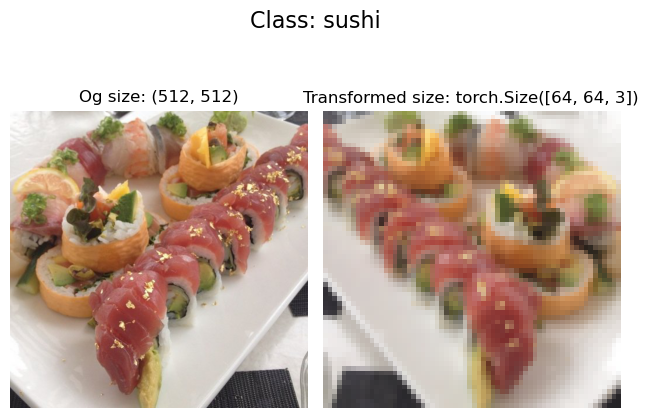

In [10]:
def plot_transformed_images(image_paths, transform, n = 3, seed = 45):
    '''Will open random n images from image_paths, transform them using transform and plot them side by side (series of plots)'''
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Og size: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed size: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)
            plt.tight_layout()

plot_transformed_images(image_path_list, data_transform, n=3)

### 4. Option 1: Loading Image Data Using ImageFolder

The data is in standard image classification format so, can use the class **torchvision.datasets.ImageFolder**

In [11]:
# Using ImageFolder to create datasets (Dataset)
train_data = datasets.ImageFolder(root = train_dir, # target folder of images
                                  transform = data_transform, # transformations over data to be performed
                                  target_transform = None) # Transforms over the labels

test_data = datasets.ImageFolder(root = test_dir, transform=data_transform)

print(f"{train_data}\n\n{test_data}")

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [12]:
# Inspecting the image data Dataset's for sanity; attributes

# Class names as a list
class_names = train_data.classes
print(class_names)

# OR class names as a dictionary
class_dict = train_data.class_to_idx
print(class_dict)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [13]:
len(train_data), len(test_data)

(225, 75)

In [14]:
# Checking with the data after turning into a Dataset
img, label = train_data[0][0], train_data[0][1]
print(img)
print(img.shape, img.dtype)
print(label, type(label))

tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0902, 0.0902, 0.

torch.Size([3, 64, 64]) torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

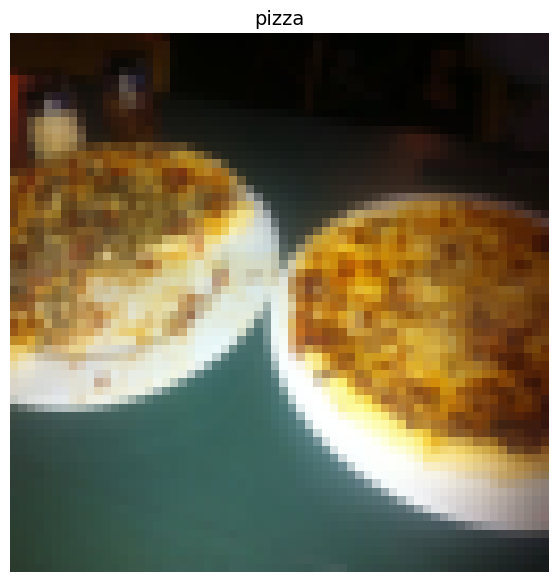

In [15]:
# Visualizing the image tensor using Matplotlib

img_permute = img.permute(1,2,0) # Needed because matplotlib works with HWC format
print(img.shape, img_permute.shape)

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

If the image is harder to recognize for what's going on by a human, it will be harder for the model to understand it too.

#### 4.1 Turn loaded images into DataLoader's

In [16]:
# Turn train and test Datasets into DataLoaders

train_dataloader = DataLoader(dataset = train_data,
                             batch_size=1, num_workers=1, # Number of subprocesses to use for data loading ? (higher value = more)
                             shuffle = True)

test_dataloader = DataLoader(dataset = test_data, batch_size=1, num_workers=1, shuffle = False) # Don't usually need to shuffle test data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1306c60fe90>,
 <torch.utils.data.dataloader.DataLoader at 0x1306c20ef50>)

In [17]:
# Check out the resulting dataloaders and their data
img, label = next(iter(train_dataloader))
print(img.shape, label.shape)

torch.Size([1, 3, 64, 64]) torch.Size([1])


### 5. Option 2: Loading Image Data with a Custom Dataset

Even though it sounds flexible, there are pros and cons of its own of the custom Dataset.

The premise is: Write code to load the data in the format one would like it in.

In [18]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
# Imported to add type hints to the code
from typing import Tuple, Dict, List

In [19]:
# Instances of ImageFolder() helped with the classes (attributes) in the data
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 5.1 Creating a helper function to get class names

In [20]:
# Fn to find classes in the target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, str]]:
    '''Finds class folder names in the target dir; assuming target dir is in std. img. classif. format'''
    # 1. Scan the target dir to get the class names
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    # 2. Raise error if class name not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")
    # 3. Create a dict of classes and their index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [21]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 5.2 Create a custom Dataset to replicate ImageFolder

Here, this will help reveal a few of the required steps to make own custom Dataset.

In [22]:
# Custom Dataset class (subclassing torch.utils.data.Dataset)

# 1. Subclass Dataset module
class ImageFolderCustom(Dataset):

    # 2. Initialize with targ_dir and transform (opt) parameters
    def __init__(self, targ_dir: dir, transform=None) -> None:

        # 3. Create class attributes (classes, class_to_idx)
            # Get all the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
            # Setup transforms to be performed
        self.transform = transform
            # Create the needed attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Image laoding fn creation
    def load_image(self, index: int) -> Image.Image:
        '''Opens image via a path and returns it.'''
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite __len__() method to use with len(Dataset) {Recommended for subclasses of torch.utils.data.Dataset class}
    def __len__(self) -> int:
        '''Returns the total number of samples.'''
        return len(self.paths)

    # 6. Overwrite __getitem__() method (reqd for the sublasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        '''Returns one data sample like (data, label).'''
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return (data, label)
        else:
            return img, class_idx

In [23]:
# Some transforms to be applied over image data to augment it
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# No augmentation of test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [24]:
# Now, the dataset are fotmed for the train and test dats using custom Dataset class
train_data_custom = ImageFolderCustom(train_dir, train_transforms)
test_data_custom = ImageFolderCustom(test_dir, test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1306c3ce150>,
 <__main__.ImageFolderCustom at 0x1306c1f8c50>)

In [25]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [26]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [27]:
# Equality check amongst custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data_custom.class_to_idx)

True
True
True


#### 5.3 Create a function to display random images

This function is created to test the __getitem__ method() overridden earlier by plotting random images.

In [28]:
# 1. Dataset and list of class names as input to the function
def display_random_images(dataset: torch.utils.data.Dataset, classes: List[str] = None, n: int = 10,
                         display_shape: bool = True, seed: int = None):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"n shouldn't be larger than 10 for display purposes and thus, setting to 10 & removing shape display.")
    # 3. Set random seed value
    if seed:
        random.seed(seed)
    # 4. Get random sample indices
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    # 5. Setup plot
    plt.figure(figsize=(16,8))
    # 6. Loop through samples and display them
    for i, sample in enumerate(random_samples_idx):
        image, label = dataset[sample][0], dataset[sample][1]
        # 7. Reshape the image tensors from CHW to HWC for compatibility with matplotlib
        image_adjust = image.permute(1,2,0)
            # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[label]}"
            if display_shape:
                title = title + f"\nshape: {image_adjust.shape}"
        plt.title(title)

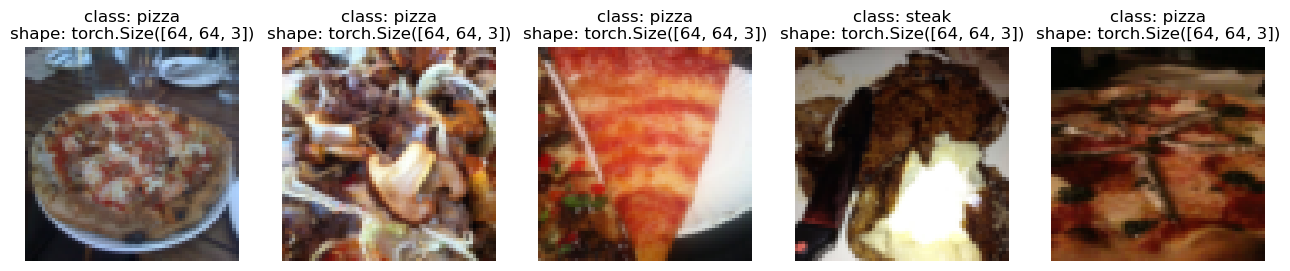

In [29]:
# Testing the fn with the ImageFolder created dataset
display_random_images(train_data, n=5, classes=class_names, seed=None)

n shouldn't be larger than 10 for display purposes and thus, setting to 10 & removing shape display.


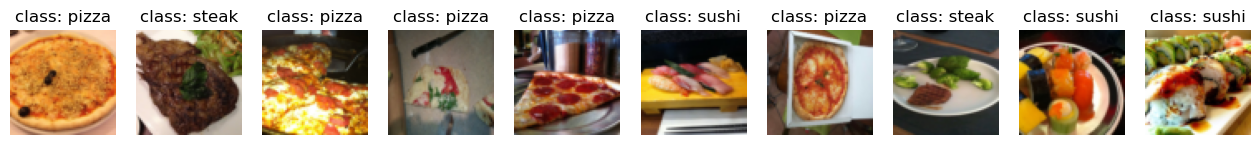

In [30]:
# Testing thee fn with the ImageFolderCustom created custom dataset
display_random_images(train_data_custom, n=12, classes=class_names, seed = None)

#### 5.4 Turning custom loaded Images into DataLoaders

In [31]:
# Turn the train and test custom Dataset;s into DataLoader's 
train_dataloader_custom = DataLoader(dataset=train_data_custom, batch_size=1, num_workers=0, shuffle = True)
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=1, num_workers=0, shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1306ceb0410>,
 <torch.utils.data.dataloader.DataLoader at 0x1306c8795d0>)

In [32]:
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

### 6. Other forms of transforms (Data Augmentation)

And, training a model on this artificially increased dataset hopefully gives a model capable of better generalization.

In [33]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # This param tells how intense should be the transforms
    transforms.ToTensor() # Its range is everything in between 0 and 1
])

# No augmentation needed
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

The size of test and train images should be the same. However, inference can be done on differnt size images if necessary but may alter performance.

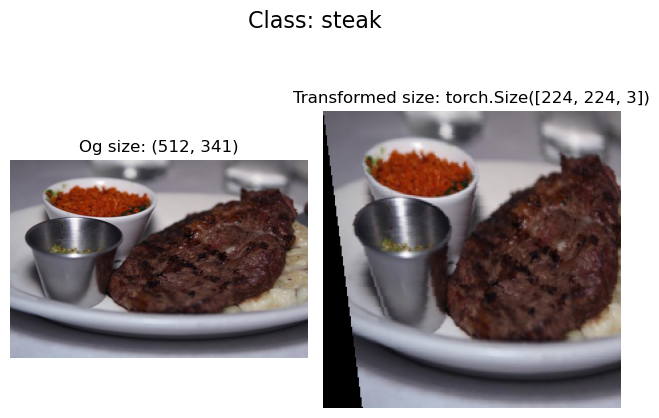

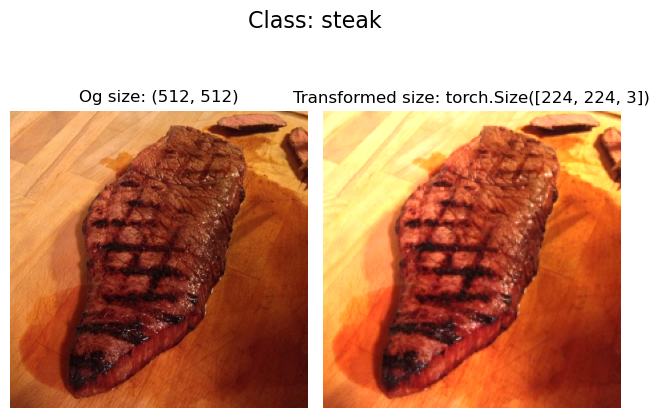

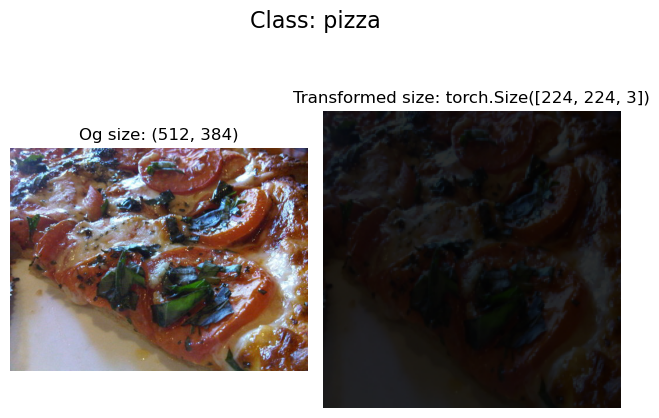

In [34]:
# Testing the data augmentation

# All image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random transformed images
plot_transformed_images(image_paths=image_path_list, transform=train_transforms, n = 3, seed = None)

### 7. Model 0: TinyVGG without data augmentation

#### 7.1 Creating transforms and loading data for Model 0

In [35]:
# To begin with simple transforms
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [36]:
# 1. Load and transform the data into Dataset
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn the Dataset into Dataloader
print(os.cpu_count())
train_dataloader_simple = DataLoader(train_data_simple, 32, shuffle = True, num_workers=os.cpu_count())
test_dataloader_simple = DataLoader(test_data_simple, 32, shuffle=False, num_workers=os.cpu_count())

train_dataloader_simple, test_dataloader_simple

12


(<torch.utils.data.dataloader.DataLoader at 0x1306ce8fd90>,
 <torch.utils.data.dataloader.DataLoader at 0x1306ce96290>)

#### 7.2 Create TinyVGG model class

In [37]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        z = self.conv_block_1(x)
        z = self.conv_block_2(z)
        z = self.classifier(z)
        return z
        # Operator fusion (avoids the overhead of reassigning the tensors)
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

torch.manual_seed(45)
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

#### 7.3 Try a forward pass on a single image (Test the model)

This is a good way to test the model by a forward pass on a single sample of data.

In [38]:
# 1 Get a single batch from the dataloader
image_batch, label_batch = next(iter(train_dataloader_simple))
# 2. Get a single image from the batch and unsqueeze it for model input compatibility
single_image, single_label = image_batch[0].unsqueeze(dim=0), label_batch[0]
print(single_image.shape)
# 3. Perform inference (forward pass)
model_0.eval()
with torch.inference_mode():
    pred = model_0(single_image.to(device))
# 4. Print what is happening
print(pred)
print(torch.softmax(pred, dim = 1))
print(torch.argmax(torch.softmax(pred, dim=1), dim=1))
print(single_label)

torch.Size([1, 3, 64, 64])
tensor([[ 0.0483, -0.0456,  0.0304]], device='cuda:0')
tensor([[0.3457, 0.3147, 0.3396]], device='cuda:0')
tensor([0], device='cuda:0')
tensor(0)


#### 7.4 Use torchinfo to get idea of the shapes going through the model

In [39]:
try:
    import torchinfo
except:
    ! pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1,3,64,64]) # test pass of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

#### 7.5 Create train & test loop functions

In [40]:
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer):
    # Training
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

In [41]:
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module):
    # Testing
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y).item()
            test_pred_labels = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

#### 7.6 Creating a train() fn to combine train_step() and test_step()

This function will train as well as evaluate the model.

In [42]:
from tqdm.auto import tqdm

# 1. Various input params reqd for train and test step fns
def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, test_datalaoder: torch.utils.data.DataLoader,
         optimizer: torch.optim.Optimizer, loss_fn: torch.nn.Module = nn.CrossEntropyLoss(), epochs: int = 5):

    # 2. Create empty dictionary for results
    results = {"train_loss" : [], "train_acc" : [], "test_loss" : [], "test_acc" : []}

    # 3. Loop through the training and testing steps of the model for #epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)

        # 4. Print what's happening
        print(f"Epoch: {epoch + 1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")

        # 5. Update the results dictionary -- Ensuring all data moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return te filled results dictionary
    return results

C:\Users\ritis\Desktop\PyTorch-Learning\pytorch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 7.7 Train and evaluate Model 0

In [43]:
# Setup the randomness seeds for reproducibility
torch.manual_seed(45)
torch.cuda.manual_seed(45)

# Setup the number of epochs to train and evaluate the model for
num_epochs=5

# Re-instantiate the model TinyVGG
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes)).to(device)

# Setup loss fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=1e-3)

# Setup and start the timer
from timeit import default_timer as timer
start_time = timer()

# Train the model_0
model_0_results = train(model_0, train_dataloader_simple, test_dataloader_simple, optimizer, loss_fn, num_epochs)

# End the timer and print the elapsed time for training and evaluating
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

 20%|████████████████▊                                                                   | 1/5 [00:41<02:46, 41.55s/it]

Epoch: 1 | train_loss: 1.1012 | train_acc: 0.2969 | test_loss: 1.1240 | test_acc: 0.2533


 40%|█████████████████████████████████▌                                                  | 2/5 [00:59<01:22, 27.59s/it]

Epoch: 2 | train_loss: 1.0901 | train_acc: 0.4141 | test_loss: 1.1308 | test_acc: 0.2533


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:17<00:46, 23.21s/it]

Epoch: 3 | train_loss: 1.1154 | train_acc: 0.2930 | test_loss: 1.1225 | test_acc: 0.2533


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:34<00:20, 20.97s/it]

Epoch: 4 | train_loss: 1.1086 | train_acc: 0.3359 | test_loss: 1.0968 | test_acc: 0.3333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:52<00:00, 22.43s/it]

Epoch: 5 | train_loss: 1.0781 | train_acc: 0.2969 | test_loss: 1.0680 | test_acc: 0.3200
Total training time: 112.137 seconds


#### 7.8 Plot the loss curves of Model 0

In [44]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [45]:
# Extract values of each of these keys and turn them into plots
def plot_loss_curves(results: Dict[str, List[float]]):
    '''Plots training curves of a results dictionary.'''
    # Loss values
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    # Accuracy values
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    # Num of epochs trained for
    epochs = range(len(results["train_loss"]))

    # Plot setup
    plt.figure(figsize=(15,7))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_acc')
    plt.plot(epochs, test_accuracy, label='test_acc')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

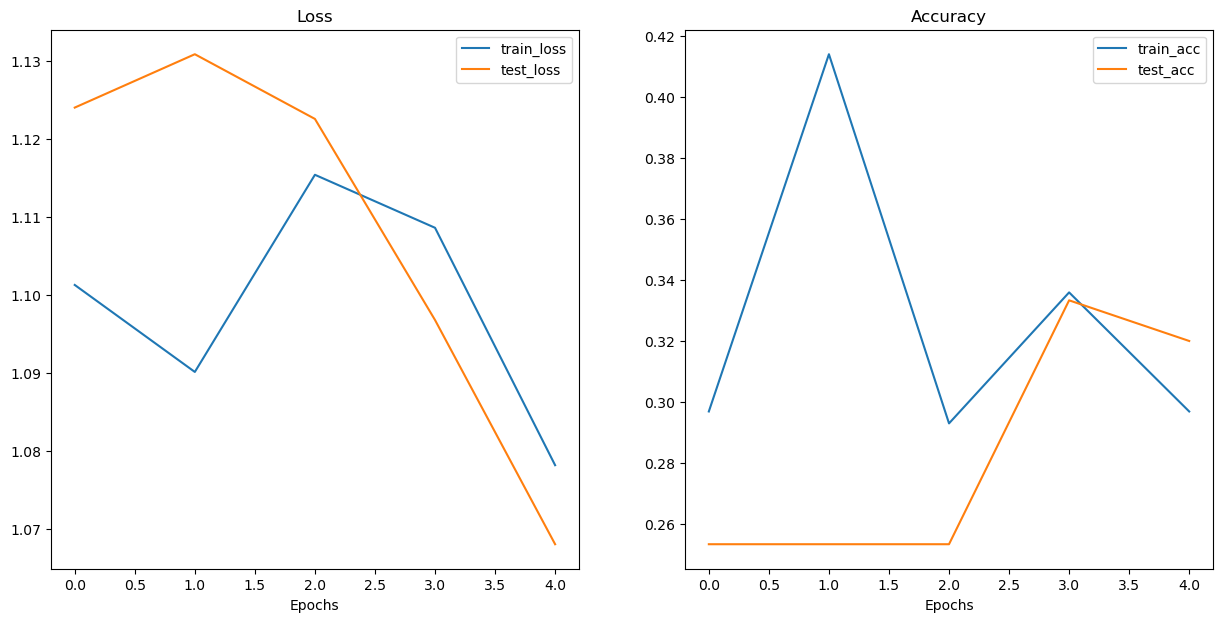

In [46]:
plot_loss_curves(model_0_results)

### 8. What should an ideal loss curve look like ?

Looking at the training and test loss curves is a great way to see if the model is **overfitting.**

Having far lower trainng loss than test loss is an indication of model overfitting.

Another side of this is when the training and test loss are not as low as expected, this is considered **underfitting.**

#### 8.1 How to deal with overfitting ?

**Regularization** is the most common technique of preventing overfitting. Think of it as making the models more regular, being capable of fitting more kinds of data.

DL is so good at learning patterns that Overfitting is one of the primary problems of DL.

#### 8.2 How to deal with underfitting ?

Underfitted models are considered to have poor predictive power on train and test sets.

#### 8.3 The balance between overfitting and underfitting

### 9. Model 1: TinyVGG with Data Augmentation

#### 9.1 Create transform with data augmentation

In [47]:
# Training transform with TrivialAugment
train_transfrom_trivial_augment = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Testing transform without data augmentation
test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

#### 9.2 Create train and test Datasets and Dataoaders

In [48]:
# Image folders into Dataset
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transfrom_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [49]:
# Dataset to DataLoader
torch.manual_seed(45)

train_dataloader_augmented = DataLoader(train_data_augmented, 32, shuffle = True, num_workers=os.cpu_count())
test_dataloader_simple = DataLoader(test_data_simple, 32, shuffle = False, num_workers=os.cpu_count())

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x1306ccec5d0>,
 <torch.utils.data.dataloader.DataLoader at 0x1306ce4a550>)

#### 9.3 Construct and train Model 1

In [50]:
torch.manual_seed(45)
model_1 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [51]:
torch.manual_seed(45)
torch.cuda.manual_seed(45)

epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimier = torch.optim.Adam(params=model_1.parameters(), lr = 0.001)

start_time = timer()

model_1_results = train(model_1, train_dataloader_augmented, test_dataloader_simple, optimizer, loss_fn, epochs)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

 20%|████████████████▊                                                                   | 1/5 [00:17<01:11, 17.82s/it]

Epoch: 1 | train_loss: 1.0949 | train_acc: 0.4453 | test_loss: 1.0940 | test_acc: 0.3333


 40%|█████████████████████████████████▌                                                  | 2/5 [00:37<00:57, 19.11s/it]

Epoch: 2 | train_loss: 1.0956 | train_acc: 0.3164 | test_loss: 1.0942 | test_acc: 0.3067


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:55<00:36, 18.26s/it]

Epoch: 3 | train_loss: 1.1056 | train_acc: 0.3008 | test_loss: 1.0944 | test_acc: 0.3067


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:13<00:18, 18.17s/it]

Epoch: 4 | train_loss: 1.0953 | train_acc: 0.4180 | test_loss: 1.0944 | test_acc: 0.3200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:31<00:00, 18.40s/it]

Epoch: 5 | train_loss: 1.0945 | train_acc: 0.4219 | test_loss: 1.0936 | test_acc: 0.3333
Total training time: 91.987 seconds


#### 9.4 Plot the loss curves of Model 1

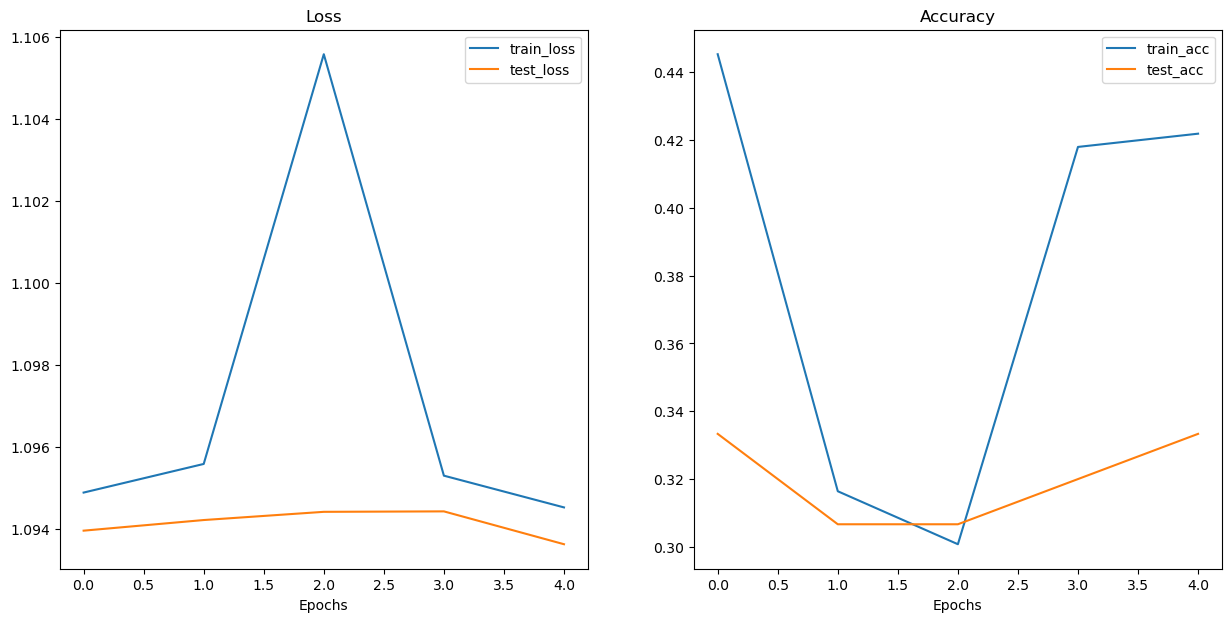

In [52]:
plot_loss_curves(model_1_results)

### 10. Compare model results

In [53]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.101249,0.296875,1.123999,0.253333
1,1.090089,0.414062,1.130845,0.253333
2,1.115380,0.292969,1.122546,0.253333
3,1.108582,0.335938,1.096752,0.333333
4,1.078128,0.296875,1.067990,0.320000


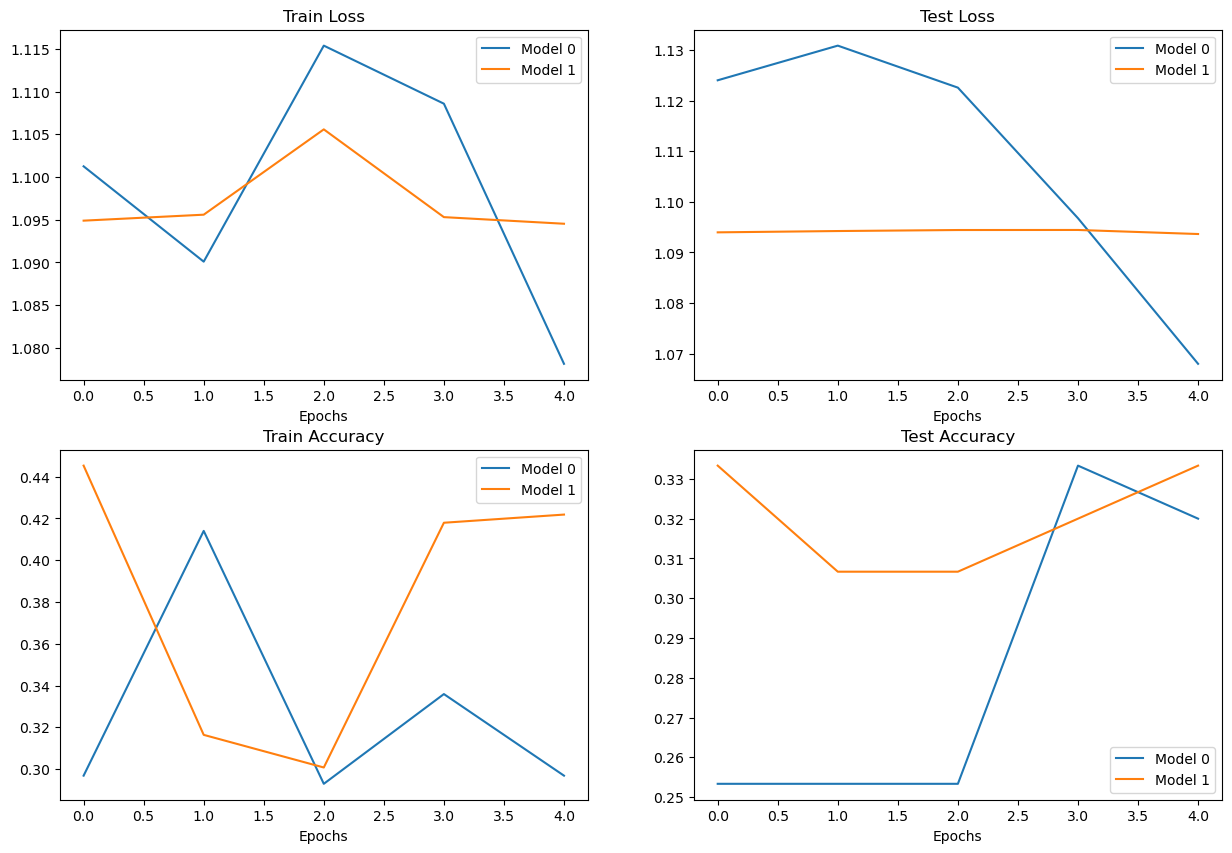

In [54]:
# Setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs the model was trained for
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["train_loss"], label = "Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["test_loss"], label = "Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["train_acc"], label = "Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["test_acc"], label = "Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

### 11. Make prediction on a custom image

In [55]:
# Download the custom image
import requests

custom_image_path = data_path / "04-pizza-author.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print("Downloading...")
        f.write(request.content)
else:
    print("Image file already exists, skipping download.")

Image file already exists, skipping download.


#### 11.1 Loading in a custom image with PyTorch

torchvision.io provides with various input and output methods for reading and writing images and video.

In [56]:
# Read in custom image
import torchvision
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

print(custom_image_uint8)
print(custom_image_uint8.shape)
print(custom_image_uint8.dtype)

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
torch.Size([3, 4032, 3024])
torch.uint8


In [57]:
# Converting the custom image into the same format as the data used by the model
# Otherwise, the model will error when tried to make prediciton

# Load the custom image and convert to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Get the pixel values in the range [0, 1] from [0, 255] by dividing by 255
custom_image = custom_image/255.

print(custom_image)
print(custom_image.shape)
print(custom_image.dtype)

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

#### 11.2 Predicting on custom images with trained PyTorch model

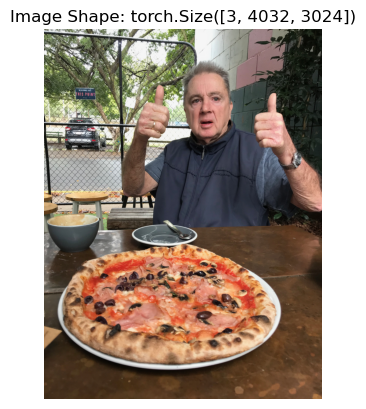

In [58]:
# Plot the custom image first -- change from CHW to HWC for matplotlib compatibility
plt.imshow(custom_image.permute(1, 2, 0))
plt.title(f"Image Shape: {custom_image.shape}")
plt.axis(False);

In [59]:
# Making the custom image of the same shape as the model train data by performing transformations
custom_image_transform = transforms.Compose([
    transforms.Resize((64,64))
])
custom_image_transformed = custom_image_transform(custom_image)
print(custom_image.shape, custom_image_transformed.shape)

torch.Size([3, 4032, 3024]) torch.Size([3, 64, 64])


In [60]:
model_1.eval()
with torch.inference_mode():
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    print(custom_image_transformed.shape, custom_image_transformed_with_batch_size.shape)

    custom_image_pred = model_1(custom_image_transformed_with_batch_size.to(device))

torch.Size([3, 64, 64]) torch.Size([1, 3, 64, 64])


**Three of the classical and most common DL and PyTorch issues are**:

1. **Wrong datatypes**; expected torch.float32 but original img was uint8, ex.
2. **Wrong device**; model was on target device while target data had not been moved to target device yet, ex.
3. **Wrong shapes**; model expected NCHW but custom image tensor was of shape CHW, ex.

In [61]:
custom_image_pred

tensor([[ 0.0339, -0.0326,  0.0308]], device='cuda:0')

In [62]:
# Convert from logits -> pred probs -> pred labels
print(custom_image_pred)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(custom_image_pred_probs)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim = 1)
print(custom_image_pred_label)

tensor([[ 0.0339, -0.0326,  0.0308]], device='cuda:0')
tensor([[0.3410, 0.3191, 0.3399]], device='cuda:0')
tensor([0], device='cuda:0')


In [63]:
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]
custom_image_pred_class

'pizza'

#### 11.3 Putting custom image prediction together: building a fn

In [64]:
def pred_and_plot_image(model: torch.nn.Module, image_path: str, class_names: List[str] = None, transform=None,
                       device: torch.device = device):
    '''Makes a prediction on a target image and plots the image with its prediction.'''

    # 1. Load the image and convert to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    # 2. Divide by 255 to get in the range [0,1]
    target_image /= 255
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    # 4. Model on the target device
    model.to(device)
    # 5. Turn on model eval mode and inference mode
    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0) # For batch size dimension
        target_image_pred = model(target_image.to(device))
    # 6. Convert from logits to pred probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    # 7. Convert from pred probs to pred label
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    # 8. Plot the image wit the prediction and its probs
    plt.imshow(target_image.squeeze().permute(1,2,0))
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

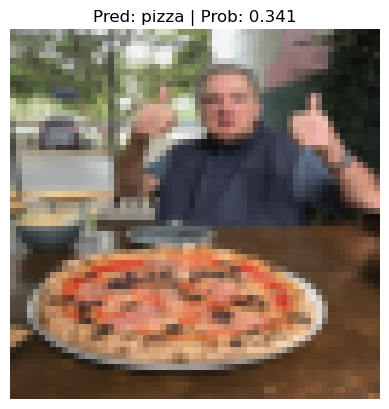

In [67]:
pred_and_plot_image(model_1, custom_image_path, class_names, custom_image_transform, device)